Project to analyze the earthquakes felt around Arad in the last 70 years

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

Going to use the USGS earthquake collection API 

In [2]:
start_time = 'now-25620days'
min_magnitude = 3
# Arad's GPS coordinates
latitude = 46.186723 
longitude = 21.305499
max_radius_km = 700

In [3]:
url = requests.get(f'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime={start_time}&minmagnitude={min_magnitude}&latitude={latitude}&longitude={longitude}&maxradiuskm={max_radius_km}')
dataset = url.json()

We need to parse the data and load it into a pandas dataframe for easier manipulation

In [5]:
dataset.keys()

dict_keys(['type', 'metadata', 'features', 'bbox'])

In [6]:
dataset = dataset['features']

In [7]:
place = []
magnitude = []
time = []
lat = []
lon = []

for feature in dataset:
    place.append(feature['properties']['place'])
    magnitude.append(feature['properties']['mag'])
    time.append(pd.to_datetime(feature['properties']['time'], unit='ms').strftime('%y/%m/%d %H:%M:%S'))
    lat.append(feature['geometry']['coordinates'][1])
    lon.append(feature['geometry']['coordinates'][0])

In [8]:
dataset_dict = {'place':place, 'magnitude':magnitude, 'time':time, 'lat':lat, 'lon':lon}

In [9]:
df = pd.DataFrame(dataset_dict)

In [10]:
df.head(-1)

,place,magnitude,time,lat,lon
0,"4 km W of Rakovica, Croatia",4.40,24/05/01 03:38:47,44.9948,15.5934
1,"7 km SSE of Eşelniţa, Romania",4.20,24/04/30 05:42:05,44.6370,22.3900
2,"20 km SSW of Plužine, Montenegro",4.40,24/04/03 10:40:45,42.9884,18.7180
3,"21 km ENE of Bileća, Bosnia and Herzegovina",4.00,24/04/02 19:07:42,42.9745,18.6501
4,"6 km ENE of Tramonti di Sopra, Italy",4.30,24/03/27 21:19:37,46.3314,12.8746
...,...,...,...,...,...
10191,"35 km ESE of Shabla, Bulgaria",5.50,56/06/30 01:50:24,43.4710,28.9590
10192,"9 km NNW of Sokolac, Bosnia and Herzegovina",5.28,56/06/28 17:42:34,44.0240,18.7770
10193,"3 km W of Ecser, Hungary",5.79,56/01/12 05:46:13,47.4430,19.2820
10194,"2 km SSE of Karyótissa, Greece",5.53,55/07/09 23:53:44,40.7460,22.3290


The next step is calculating the distance from our original coordinates (Arad).

In [11]:

def calculate_distance(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    # Calculate the change in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Calculate the distance
    distance = R * c

    return np.round(distance,2)

In [12]:
df['distance'] = df.apply(lambda row:calculate_distance(latitude,longitude, row['lat'],row['lon']) , axis = 1)

In [13]:
df

,place,magnitude,time,lat,lon,distance
0,"4 km W of Rakovica, Croatia",4.40,24/05/01 03:38:47,44.9948,15.5934,463.69
1,"7 km SSE of Eşelniţa, Romania",4.20,24/04/30 05:42:05,44.6370,22.3900,191.99
2,"20 km SSW of Plužine, Montenegro",4.40,24/04/03 10:40:45,42.9884,18.7180,410.39
3,"21 km ENE of Bileća, Bosnia and Herzegovina",4.00,24/04/02 19:07:42,42.9745,18.6501,414.44
4,"6 km ENE of Tramonti di Sopra, Italy",4.30,24/03/27 21:19:37,46.3314,12.8746,648.06
...,...,...,...,...,...,...
10192,"9 km NNW of Sokolac, Bosnia and Herzegovina",5.28,56/06/28 17:42:34,44.0240,18.7770,311.75
10193,"3 km W of Ecser, Hungary",5.79,56/01/12 05:46:13,47.4430,19.2820,207.89
10194,"2 km SSE of Karyótissa, Greece",5.53,55/07/09 23:53:44,40.7460,22.3290,610.58
10195,"9 km SSE of Chalástra, Greece",5.13,54/12/30 02:07:24,40.5430,22.7570,638.40


Now let's convert the time into a datetime pandas object

In [14]:
def parse_data(x):
    x = x.split(' ')[0]
    year, month, date = x.split('/')

    if year >='36':
        year = '19' + year
    else:
        year = '20' + year
    return pd.to_datetime(f'{year}-{month}-{date}')


In [15]:
df['time'] = df['time'].apply(lambda x:parse_data(x))

In [16]:
df

,place,magnitude,time,lat,lon,distance
0,"4 km W of Rakovica, Croatia",4.40,2024-05-01,44.9948,15.5934,463.69
1,"7 km SSE of Eşelniţa, Romania",4.20,2024-04-30,44.6370,22.3900,191.99
2,"20 km SSW of Plužine, Montenegro",4.40,2024-04-03,42.9884,18.7180,410.39
3,"21 km ENE of Bileća, Bosnia and Herzegovina",4.00,2024-04-02,42.9745,18.6501,414.44
4,"6 km ENE of Tramonti di Sopra, Italy",4.30,2024-03-27,46.3314,12.8746,648.06
...,...,...,...,...,...,...
10192,"9 km NNW of Sokolac, Bosnia and Herzegovina",5.28,1956-06-28,44.0240,18.7770,311.75
10193,"3 km W of Ecser, Hungary",5.79,1956-01-12,47.4430,19.2820,207.89
10194,"2 km SSE of Karyótissa, Greece",5.53,1955-07-09,40.7460,22.3290,610.58
10195,"9 km SSE of Chalástra, Greece",5.13,1954-12-30,40.5430,22.7570,638.40


In [17]:
df.dtypes

place                object
magnitude           float64
time         datetime64[ns]
lat                 float64
lon                 float64
distance            float64
dtype: object

We need a way to sort the earthquakes by their approximated impact on Arad. While magnitude is not dirrectly correlated to the distance, it is impossible to find an exact formula for what we need.
What we know, though, is that an earthquake with a higher magnitude and a shorter distance from Arad is felt the most. Using this logic, it is easy to deduce the ratio of MAGNITUDE/DISTANCE. However, the magnitude on the richter scale scales exponentially. This is not an exact number, but I tweaked with the power that we raise it until on the top earthquakes list we could find the earthquakes that locals remember experiencing in this city. The notable earthquakes that we were looking for are: the 2 earthquakes in 2023 that happened in Arad county (which I have personally experienced), the biggest and most destructive earthquake in Romania (1977, near Bucharest) and the 1991 Ciacova earthquake.
Knowing these 4 earthquakes that people said they felt while living in Arad, we can tweak with the power we raise the magnitude by to get an approximation of the correlation between magnitude and distance. This is not a highly accurrate formula, because a high magnitude does not necessarily mean a large radius, but due to the lack of data, this is the closest formula I could get to retrieve a list of the most "felt" earthquakes in Arad.

In [18]:
df['ratio'] = df.apply(lambda x:(x['magnitude']**6.5)/x['distance'], axis=1)

In [19]:
df.sort_values('ratio', ascending=False)[:10][['place','time','magnitude', 'distance', 'ratio']]

,place,time,magnitude,distance,ratio
10089,"4 km S of M?n??tur, Romania",1974-04-17,5.60,27.04,2699.078329
51,"6 km SW of Frumu?eni, Romania",2023-06-06,4.70,15.47,1510.587070
9868,"2 km N of Spulber, Romania",1977-03-04,7.50,423.98,1149.616111
8181,"7 km NNE of Ca?oca, Romania",1986-08-30,7.20,394.35,947.936796
6648,"1 km SW of Ciacova, Romania",1991-12-02,5.50,77.99,832.374106
10183,"6 km ESE of Cenei, Romania",1959-05-27,5.28,60.09,828.549181
52,"2 km S of Fântânele, Romania",2023-05-22,4.10,11.70,822.070771
6813,"2 km S of Livezile, Romania",1991-07-12,5.60,93.49,780.651171
7185,"5 km W of Nistore?ti, Romania",1990-05-30,7.00,415.81,748.587085
9614,"6 km E of Stari Bar, Montenegro",1979-04-15,6.90,484.61,584.960739


Now let's get a closer look to the earthquakes that had their epicenters close to Arad

In [39]:
df_close = df[df['distance']<=100].copy(deep=True)
df_close

,place,magnitude,time,lat,lon,distance,ratio
36,"6 km SE of Szarvas, Hungary",3.50,2023-08-20,46.8276,20.6207,88.46,38.877234
37,"10 km E of Szarvas, Hungary",3.40,2023-08-19,46.8563,20.6839,88.35,32.240844
38,"10 km ESE of Szarvas, Hungary",3.70,2023-08-19,46.8358,20.6764,86.76,56.884201
39,"10 km ESE of Szarvas, Hungary",3.60,2023-08-19,46.8446,20.6875,87.11,47.413088
51,"6 km SW of Frumu?eni, Romania",4.70,2023-06-06,46.0645,21.4014,15.47,1510.587070
...,...,...,...,...,...,...,...
9722,"6 km SSE of Szeghalom, Hungary",3.20,1978-06-22,46.9780,21.1910,88.42,21.723227
9723,"3 km NW of Békés, Hungary",4.40,1978-06-22,46.7880,21.1010,68.67,221.653886
9724,"5 km NW of Békéscsaba, Hungary",4.60,1978-06-22,46.7160,21.0550,61.90,328.273070
10089,"4 km S of M?n??tur, Romania",5.60,1974-04-17,45.9720,21.1410,27.04,2699.078329


I want to see a graph of the number of earthquakes that happened each year

Let's add a year column and group the values by that column

In [42]:
df_close['year'] = df_close['time'].dt.year
df_close

,place,magnitude,time,lat,lon,distance,ratio,year
36,"6 km SE of Szarvas, Hungary",3.50,2023-08-20,46.8276,20.6207,88.46,38.877234,2023
37,"10 km E of Szarvas, Hungary",3.40,2023-08-19,46.8563,20.6839,88.35,32.240844,2023
38,"10 km ESE of Szarvas, Hungary",3.70,2023-08-19,46.8358,20.6764,86.76,56.884201,2023
39,"10 km ESE of Szarvas, Hungary",3.60,2023-08-19,46.8446,20.6875,87.11,47.413088,2023
51,"6 km SW of Frumu?eni, Romania",4.70,2023-06-06,46.0645,21.4014,15.47,1510.587070,2023
...,...,...,...,...,...,...,...,...
9722,"6 km SSE of Szeghalom, Hungary",3.20,1978-06-22,46.9780,21.1910,88.42,21.723227,1978
9723,"3 km NW of Békés, Hungary",4.40,1978-06-22,46.7880,21.1010,68.67,221.653886,1978
9724,"5 km NW of Békéscsaba, Hungary",4.60,1978-06-22,46.7160,21.0550,61.90,328.273070,1978
10089,"4 km S of M?n??tur, Romania",5.60,1974-04-17,45.9720,21.1410,27.04,2699.078329,1974


In [72]:
eq_per_yr = df_close.value_counts('year')

for yr in range(eq_per_yr.index.min(), eq_per_yr.index.max()+1):
    if yr not in eq_per_yr.index:
        eq_per_yr[yr]=0
eq_per_yr = eq_per_yr.sort_index()
eq_per_yr

year
1959    1
1960    0
1961    0
1962    0
1963    0
       ..
2019    0
2020    0
2021    0
2022    0
2023    6
Name: count, Length: 65, dtype: int64

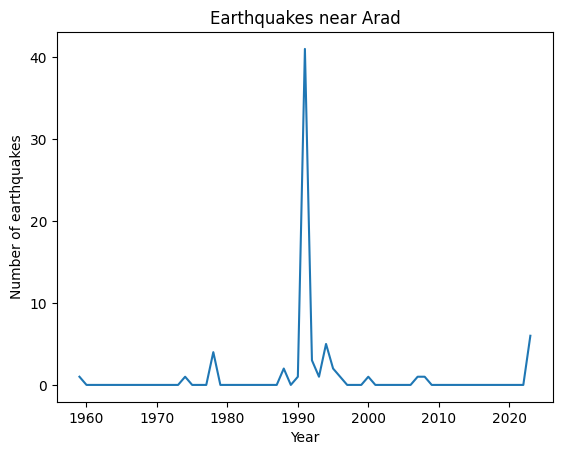

In [65]:
plt.plot(eq_per_yr.index, eq_per_yr.values)
plt.xlabel('Year')
plt.ylabel('Number of earthquakes')
plt.title('Earthquakes near Arad')
plt.show()

We can see that an extreme amount of earthquakes occurred near Arad in 1991.

In [77]:
df_close[df_close['year']==1991].sort_values('time')

,place,magnitude,time,lat,lon,distance,ratio,year
6813,"2 km S of Livezile, Romania",5.6,1991-07-12,45.364,21.057,93.49,780.651171,1991
6812,"3 km SE of Ghilad, Romania",4.1,1991-07-12,45.446,21.167,83.06,115.798555,1991
6810,"3 km S of Banloc, Romania",3.5,1991-07-13,45.358,21.137,93.07,36.951543,1991
6811,"2 km NE of Deta, Romania",4.0,1991-07-13,45.403,21.241,87.29,93.848093,1991
6809,Romania,3.3,1991-07-14,45.404,21.076,88.83,26.410763,1991
6807,"3 km S of Ghilad, Romania",4.1,1991-07-14,45.431,21.129,85.14,112.969556,1991
6804,"4 km SSW of Banloc, Romania",4.4,1991-07-19,45.344,21.123,94.77,160.609606,1991
6803,"7 km ENE of Stari Lec, Serbia",5.1,1991-07-19,45.312,21.053,99.22,400.504059,1991
6801,"1 km SE of Deta, Romania",3.8,1991-07-20,45.375,21.240,90.40,64.926942,1991
6800,"5 km SSW of Banloc, Romania",4.1,1991-07-20,45.346,21.108,94.73,101.533073,1991
